# Mohammad, Sara, Maryam  

In [1]:
import numpy as np
import pandas as pd
import json
import requests
import time
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
import pandas as pd
import pylab
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import unittest
import copy

In [2]:
class pull_request_info():
    def __init__(self, owner, name, number):
        res = requests.get("https://api.github.com/repos/" + owner + "/" + name + "/pulls/" + str(number) + "?access_token=86bf544226d76cbc47189cc117e74bb1202aeb72")
        res_json = res.json()
        
        self.owner = owner
        self.name = name

        if res_json["title"] != None:
            self.title = "\"" + res_json["title"].replace('\"', '\\"').replace("\r", " ").replace("\n", " ").replace(",", " ")  + "\""
        else:
            self.title = "None"
        
        self.number = res_json["number"]
        
        self.body = res_json["body"]
        if res_json["body"] != "" :
            self.body = "\"" + self.body.replace('\"', '\\"').replace("\r", " ").replace("\n", " ").replace(",", " ") + "\""
        else : 
            self.body = "None"
            
        self.state = res_json["state"]
        self.created_at = res_json["created_at"]
        if self.state == "closed":
            self.closed_at = res_json["closed_at"]
        else :
            self.closed_at = "Null"
        self.user = res_json["user"]["login"]
        self.commits = res_json["commits"]
        self.additions = res_json["additions"]
        self.deletions = res_json["deletions"]
        self.changed_files = res_json["changed_files"]
        
    def to_CSV(self):
        path = "./repos"
        filename = path + "/" + self.owner + "-" + self.name + ".csv"
        header = "title," + "number," + "state," + "created_at," + "user," + "commits," + "additions," + "deletions," + "changed_files," + "closed_at," + "body\n"
        content = self.title + "," + str(self.number) + "," + self.state + "," + self.created_at + "," + self.user + "," + str(self.commits) + "," + str(self.additions) + "," + str(self.deletions) + "," + str(self.changed_files) + "," + self.closed_at + "," + self.body + "\n"
        if os.path.exists(path) == False:
            os.mkdir(path)
        if os.path.exists(filename) == False:
            fd = open(filename, "a+", encoding = "utf8")
            fd.writelines(header)
            fd.writelines(content)
            fd.close()
        else :
            fd = open(filename, "a+", encoding='utf8')
            fd.writelines(content)
            fd.close()
            
            
        filename = path + "/allProject.csv"
        header = "title," + "number," + "state," + "created_at," + "user," + "commits," + "additions," + "deletions," + "changed_files," + "closed_at," + "body\n"
        content = self.title + "," + str(self.number) + "," + self.state + "," + self.created_at + "," + self.user + "," + str(self.commits) + "," + str(self.additions) + "," + str(self.deletions) + "," + str(self.changed_files) + "," + self.closed_at + "," + self.body + "\n"
        if os.path.exists(path) == False:
            os.mkdir(path)
        if os.path.exists(filename) == False:
            fd = open(filename, "a+", encoding = "utf8")
            fd.writelines(header)
            fd.writelines(content)
            fd.close()
        else :
            fd = open(filename, "a+", encoding='utf8')
            fd.writelines(content)
            fd.close()


In [3]:
class LICENSE:
    def __init__(self, key, name, spdx_id, url, node_id):
        self.key = key
        self.name = name
        self.spdx_id = spdx_id
        self.url = url
        self.node_id = node_id
        
    def to_str(self):
        dic = {}
        dic["key"] = self.key
        dic["name"] = self.name
        dic["spdx_id"] = self.spdx_id
        dic["url"] = self.url
        dic["node_id"] = self.node_id
        str1= "\"" + str(dic) + "\""
        return str1

In [4]:
class user_info:
    def __init__(self, login, logins):

        self.login = login
        self.num_pull_req = 0
        self.personal_account = 1
        for item in logins:
            if item == login:
                self.num_pull_req = self.num_pull_req + 1

        res1 = requests.get("https://github.com/" + login)
        soup = BeautifulSoup(res1.text, "html.parser")
        num_rep = soup.find_all("span", "Counter")
        infos = soup.find_all("span", "text-bold text-gray-dark")

        if len(infos) != 3:
            self.personal_account = 0
        else:
            self.num_repo = int(num_rep[0].get_text().strip().replace("k", "000").replace(",", "").replace(",", "").replace(".", ""))
            self.num_followers = int(infos[0].get_text().strip().replace("k", "000").replace(",", "").replace(".", ""))
            self.num_following = int(infos[1].get_text().strip().replace("k", "000").replace(",", "").replace(".", ""))
            self.contributions_last_year = int(soup.find_all("h2", "f4 text-normal mb-2")[0].get_text().strip().split(" ")[0].replace(",", "").replace(".", ""))

    def to_CSV(self):
        filename = "users.csv"
        header = "login," + "num_pull_req," + "num_repo," + "num_followers," + "num_following," + "contributions_last_year\n"
        if self.personal_account == 1:
            content = self.login + "," + str(self.num_pull_req) + "," + str(self.num_repo) + "," + str(self.num_followers) + "," + str(self.num_following) + "," + str(self.contributions_last_year) + "\n"
        if os.path.exists(filename) == False:
            fd = open(filename, "a+", encoding = "utf8")
            fd.writelines(header)
            if self.personal_account == 1:
                fd.writelines(content)
            fd.close()
        else :
            if self.personal_account == 1:
                dataset = pd.read_csv("users.csv")
                if len(dataset[dataset["login"] == self.login]) == 0 :
                    fd = open(filename, "a+", encoding = "utf8")
                    fd.writelines(content)
                    fd.close()

In [5]:
class project_info(LICENSE, pull_request_info, user_info):
    def __init__(self, owner, name):
        
        res = requests.get("https://api.github.com/repos/" + owner + "/" + name + \
                           "?access_token=86bf544226d76cbc47189cc117e74bb1202aeb72")
        
        res_json = res.json()
        
        self.owner = res_json["owner"]["login"]
        self.name = res_json["name"]
        
        if res_json["description"] != None:
            self.description = res_json["description"]
        else :
            self.description = "None"
        
        if res_json["homepage"] != None:
            self.homepage = res_json["homepage"]
        else :
            self.homepage = "None"
        
        if res_json["license"] != None:
            self.license = LICENSE(res_json["license"]["key"], res_json["license"]["name"], res_json["license"]["spdx_id"], res_json["license"]["url"], res_json["license"]["node_id"])
        else :
            self.license = res_json["license"]
            
            
        self.forks = res_json["forks_count"]
        self.watchers = res_json["watchers_count"]
        self.date_of_collection = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        self.stars = res_json["stargazers_count"]
        
        self.pull_requests_list = []
        self.logins = []
        self.user_info_list = []
        self.num_users = 0
        
        self.get_pull_request_info()
        self.get_user_info()
        
        self.to_CSV()
        
        for item in self.user_info_list:
            item.to_CSV()
        for item in self.pull_requests_list:
            item.to_CSV()
    
    
    def get_user_info(self):
        res = requests.get("https://api.github.com/search/issues?q=is:pr+repo:" + self.owner + "/" + self.name + "?access_token=8403d54375bcfc49b96ee7bceb2703430d38c91b")
        logins_tmp = list(set(self.logins))
        self.num_users = len(logins_tmp)
        for login in logins_tmp:
            self.user_info_list.append(user_info(login, self.logins))
            
    
    def get_pull_request_info(self):
        res = requests.get("https://api.github.com/search/issues?q=is:pr+repo:" + self.owner + "/" + self.name)#  + "?access_token=8403d54375bcfc49b96ee7bceb2703430d38c91b")
        res_json = res.json()
        items = res_json["items"]
        for item in items:
            self.pull_requests_list.append(pull_request_info(self.owner, self.name, item["number"]))
            self.logins.append(item["user"]["login"])
            
            
    def to_CSV(self):
        filename = "./repos.csv"
        header = "owner," + "name," + "description," + "homepage," + "forks," + "watchers," + "date_of_collection," + "license\n" 
        content = self.owner + "," + self.name + "," + self.description + "," + self.homepage + "," + str(self.forks) + "," + str(self.watchers) + "," + self.date_of_collection + ","
        
        if self.license == None:
            content += "None\n"
        else :
            content += (self.license.to_str() + "\n")
        
        if os.path.exists(filename) == True :
            fd = open(filename, "a+", encoding = "utf8")
            fd.writelines(content)
            fd.close()
        else :
            fd = open(filename, "a+", encoding = "utf8")
            fd.writelines(header)
            fd.writelines(content)
            fd.close()

In [6]:
def start_get_data(owner, name):
    res = requests.get("http://github.com/" + owner + "/" + name)
    if res.status_code == 404:
        print("No such repo!")
        return False
    return project_info(owner, name)

In [7]:
def list_all_repo():
    if os.path.exists("repos.csv") == False:
        print("No repo collected!")
        return
    dataset = pd.read_csv("repos.csv", usecols = ["owner", "name"])
    print(dataset)

In [8]:
def list_pull_req_from_repo():
    if os.path.exists("repos.csv") == False:
        print("No repo collected!")
        return
    print("Please select one from repos listed:")
    dataset = pd.read_csv("repos.csv", usecols = ["owner", "name"])
    print(dataset)
    index = int(input("Please input the index of the repo (from the first column shown above):"))
    
    repo = dataset.loc[index]
    
    file = "./repos/" + repo["owner"] + "-" + repo["name"] + ".csv"
    pull_reqs = pd.read_csv(file, usecols = ["number", "title"])
    print(pull_reqs)

In [9]:
def summary_of_repo():
    if os.path.exists("repos.csv") == False:
        print("No repo collected!")
        return
    print("Please select one from repos listed:")
    dataset = pd.read_csv("repos.csv", usecols = ["owner", "name"])
    print(dataset)
    index = int(input("Please input the index of the repo (from the first column shown above):"))
    repo = dataset.loc[index]
    file = "./repos/" + repo["owner"] + "-" + repo["name"] + ".csv"
    dataset = pd.read_csv(file)
    
    state_closed = len(dataset[dataset.state == "closed"])
    state_open = len(dataset[dataset.state == "open"])
    
    num_users = len(dataset.user.unique())
    users = dataset.user.unique().tolist()

    tmp = dataset.sort_values("created_at", ascending = True)
    created_at = tmp.loc[len(tmp) - 1].created_at
    

    print("-------------------summary---------------------:")
    print("""
number of pull requests in open state: %d\n\
number of pull requests in closed state: %d\n\
number of users: %d\n\
date of the oldest pull requested: %s\n\
""" %(state_open, state_closed, num_users, created_at))
    

In [10]:
def create_graphics_repo(owner,name):
    path = "./repos"
    filename = path + "/" + owner + "-" + name + ".csv"
    dataset = pd.read_csv(filename)
    
    opened = dataset.state=="open"
    closed = dataset.state=="closed"
    
    set_opened = dataset[opened]
    set_closed = dataset[closed]

    A= [set_opened['commits'],  set_closed['commits']]
    B = [set_opened['additions'],  set_closed['additions']]
    C = [set_opened['deletions'],  set_closed['deletions']]

    fig = plt.figure(figsize=(30,20))
    plot = plt.boxplot(A, widths = 0.6)
    plt.xlabel("commits")
    plt.ylabel("The number of pull requests")
    plt.title("Closed and open pull requests in terms of number of commits")
    show()
    
    fig = plt.figure(figsize=(30,20))
    plot = plt.boxplot(B, widths = 0.6)
    plt.xlabel("Additions")
    plt.ylabel("The number of pull requests")
    plt.title("Closed and open pull requests in terms of number of additions")
    show()
    
    fig = plt.figure(figsize=(30,20))
    plot = plt.boxplot(C, widths = 0.6)
    plt.xlabel("Deletions")
    plt.ylabel("The number of pull requests")
    plt.title("Closed and open pull requests in terms of number of deletions")
    show()

    fig = plt.figure(figsize=(20,10))
    result= dataset.groupby(["user"]).sum()
    plot = plt.boxplot(result.changed_files)
    plt.title("Number of Changed Files Grouped by the Author Association")
    plt.show()
    
    fig = plt.figure(figsize=(20,10))
    plt.scatter(x = dataset.additions,y = dataset.deletions, s = 100)
    plt.title("Additions vs Deletions")
    plt.xlabel("Additions")
    plt.ylabel("Deletions")
    plt.show()

In [11]:
def create_graphics_all():
    path = "./repos"
    filename = path + "/" + "allProject.csv"
    
    if os.path.exists(path) == False:
        print("All of the repos have no pull requests!")
        return
    
    dataset = pd.read_csv(filename)

    opened = dataset.state=="open"
    closed = dataset.state=="closed"
    
    result = copy.deepcopy(dataset)
    result["day"] = result['created_at']
    result["day"] = result['day'].str.split('T',expand=True)
    result["counter"] = np.ones(len(result))
    
    set_opened = result[opened]
    set_closed = result[closed]
    
    set_opened_day = set_opened.groupby(["day"]).sum()
    set_opened_day = set_opened_day.sort_values("day", ascending = True)

    set_closed_day = set_closed.groupby(["day"]).sum()
    set_closed_day = set_closed_day.sort_values("day", ascending = True)

    set_opened_or_closed = result.groupby(["day"]).sum()
    set_opened_or_closed = set_opened_or_closed.sort_values("day", ascending = True)

    fig = plt.figure(figsize=(30,20))
    plt.plot(set_opened_day.index, set_opened_day["counter"])
    plt.xticks(rotation = 'vertical')
    plt.xlabel("Time")
    plt.ylabel("The number of pull request")
    plt.title("The number of open pull requests per day")
    plt.tight_layout() 

    fig = plt.figure(figsize=(30,20))
    plt.plot(set_closed_day.index, set_closed_day["counter"])
    plt.xticks(rotation = 'vertical')
    plt.xlabel("Time")
    plt.ylabel("The number of pull request")
    plt.title("The number of closed pull requests per day")
    plt.tight_layout() 
    
    fig = plt.figure(figsize=(30,20))
    plt.plot(set_opened_or_closed.index, set_opened_or_closed["counter"])
    plt.xticks(rotation = 'vertical')
    plt.xlabel("Time")
    plt.ylabel("The number of pull request")
    plt.title("The number of all pull requests per day")
    plt.tight_layout() 
    
    
    fig = plt.figure(figsize=(30,20))
    path = "./repos"
    klist = []
    for i,j,k in os.walk(path):
        klist.append(k)
    #print(klist)
    klist[0].remove('allProject.csv')
    #klist.remove([])
    #print(klist)
    klist = klist[0]
    files = copy.deepcopy(klist)
    num_user=[]
    for i in range(len(klist)):
        filename = path + "/" + klist[i]
        print(filename)
        dataset = pd.read_csv(filename)
        size  = len(dataset.user.unique())
        num_user.append(size)
    plt.bar(x=files, height=num_user)

    plt.xlabel("Repo")
    plt.xticks(rotation = 'vertical')
    plt.ylabel("The Number of Users")
    plt.show()

In [12]:
def corr_between_datas():
    
    filename = "users.csv"
    dataset = pd.read_csv(filename, usecols=["num_pull_req", "contributions_last_year", "num_followers", "num_following"])
    print(dataset.corr())

In [13]:
def corr_in_pull_request(owner, name):
    path = "./repos"
    filename = path + "/" + owner + "-" + name + ".csv"
    dataset = pd.read_csv(filename)
    print(dataset.corr())


please input one option between 1 to 9:
1---Start to Collect data: 
2---list repos collected
3---list all pull requests from a repo.
4---list the summary of a repo
5---create graphics given a repo
6---create graphics considering ALL pull requests from all repos.
7---calculate the correlation between the data collected for a user (following, followers, number of pull requests, number of contributions, etc.).
8---calculate the correlation between all the numeric data in the pull requests for a repo.
9---exit.
1
input the repo owner name:rails
input the repo name:rails
Loading ...
Press enter to continue!

please input one option between 1 to 9:
1---Start to Collect data: 
2---list repos collected
3---list all pull requests from a repo.
4---list the summary of a repo
5---create graphics given a repo
6---create graphics considering ALL pull requests from all repos.
7---calculate the correlation between the data collected for a user (following, followers, number of pull requests, number of

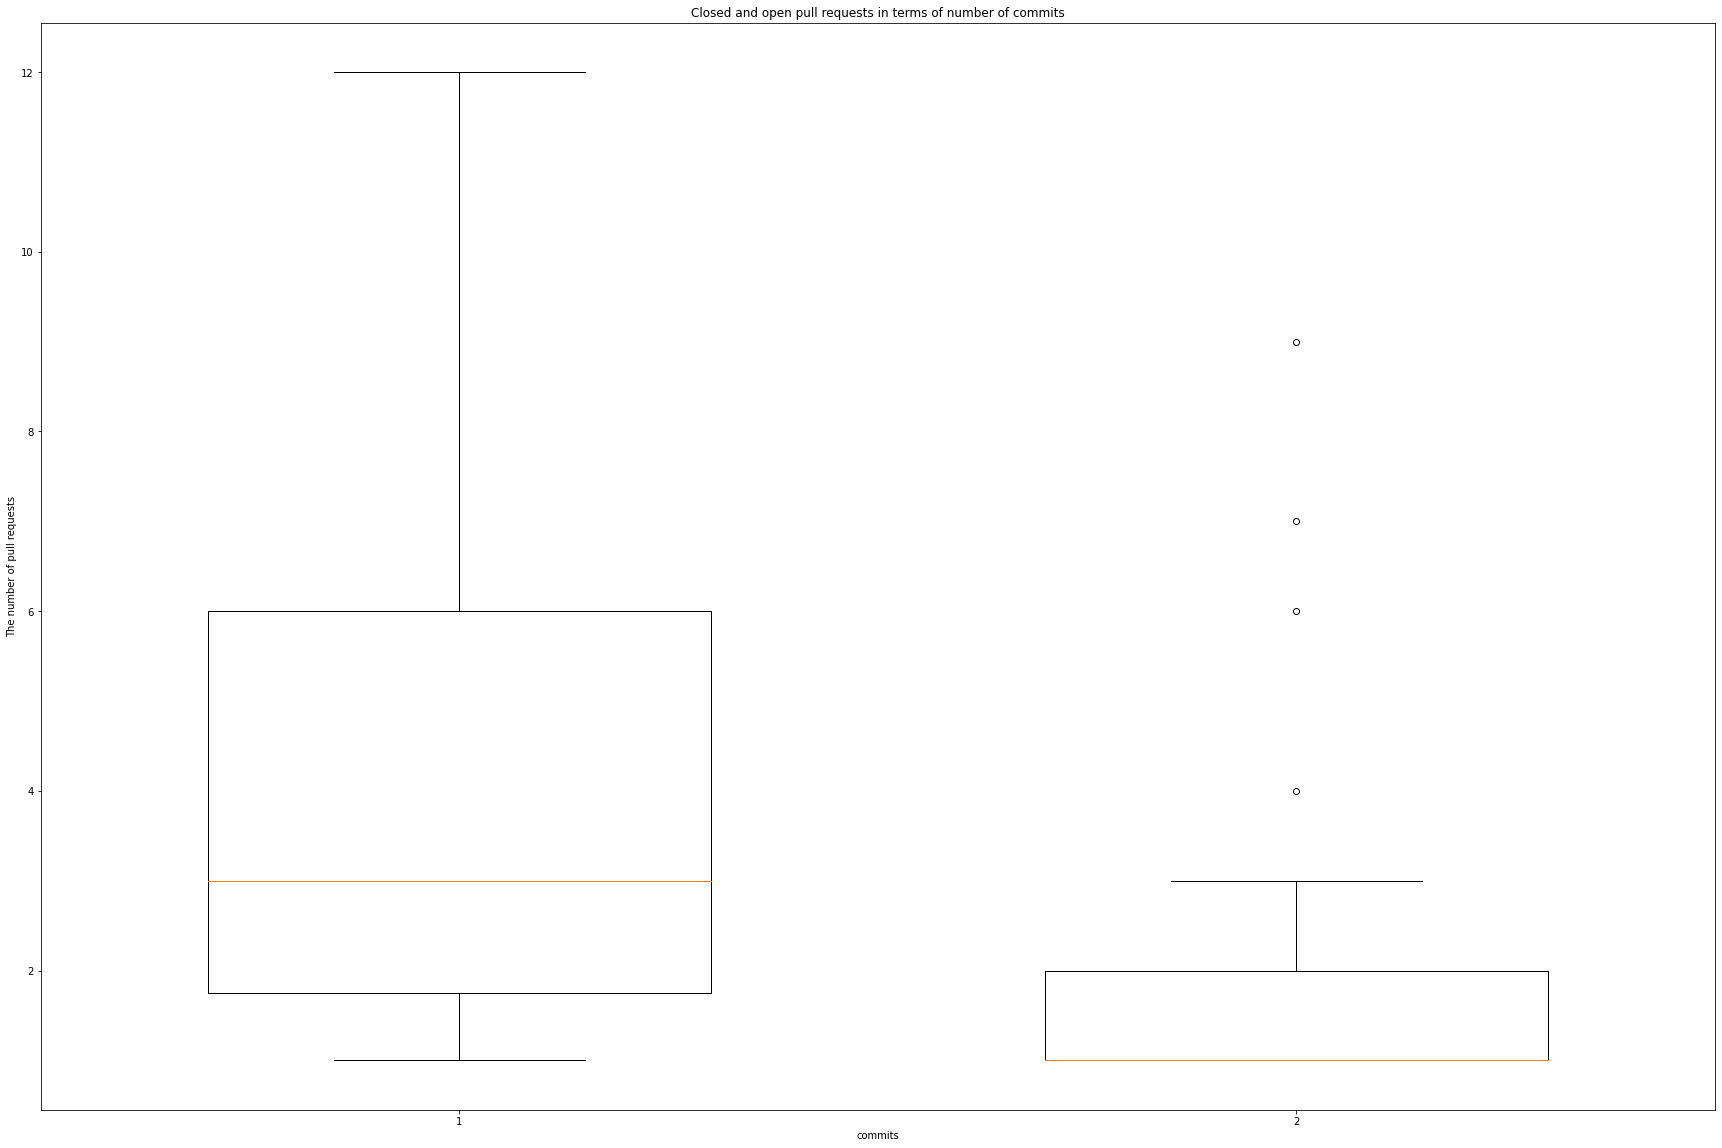

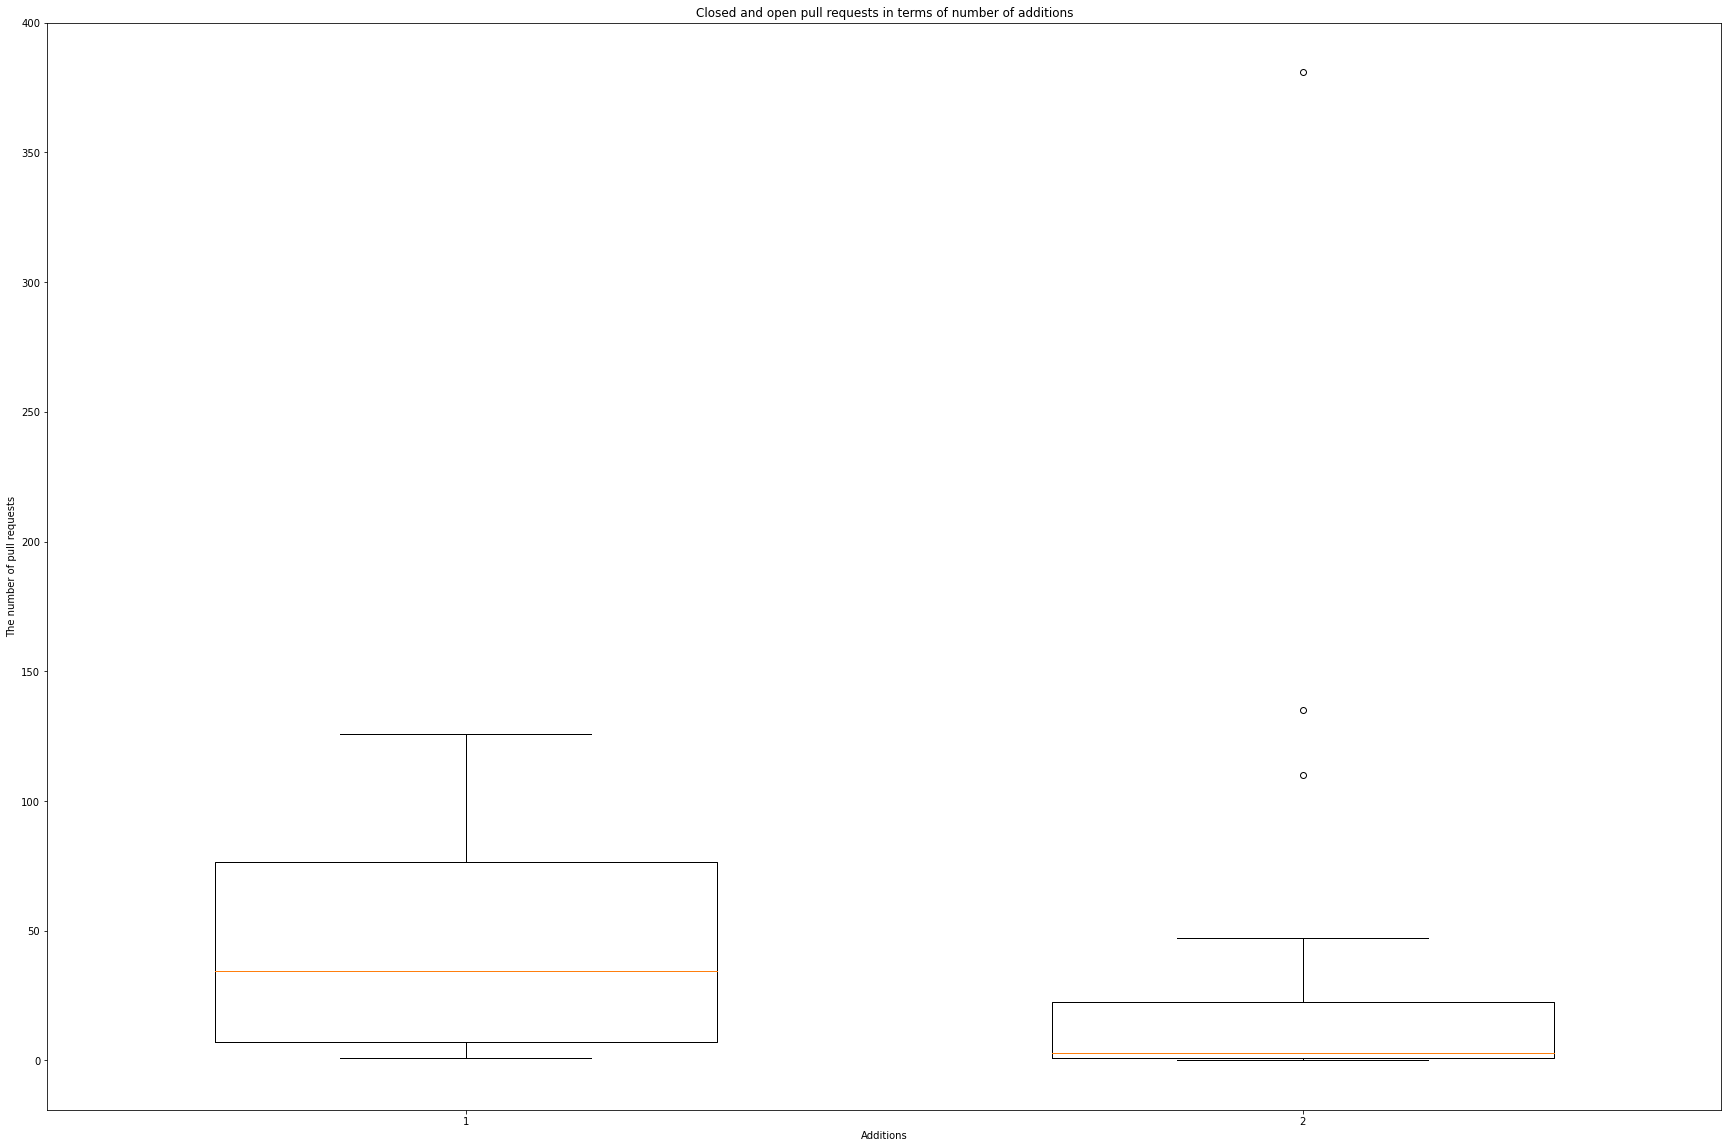

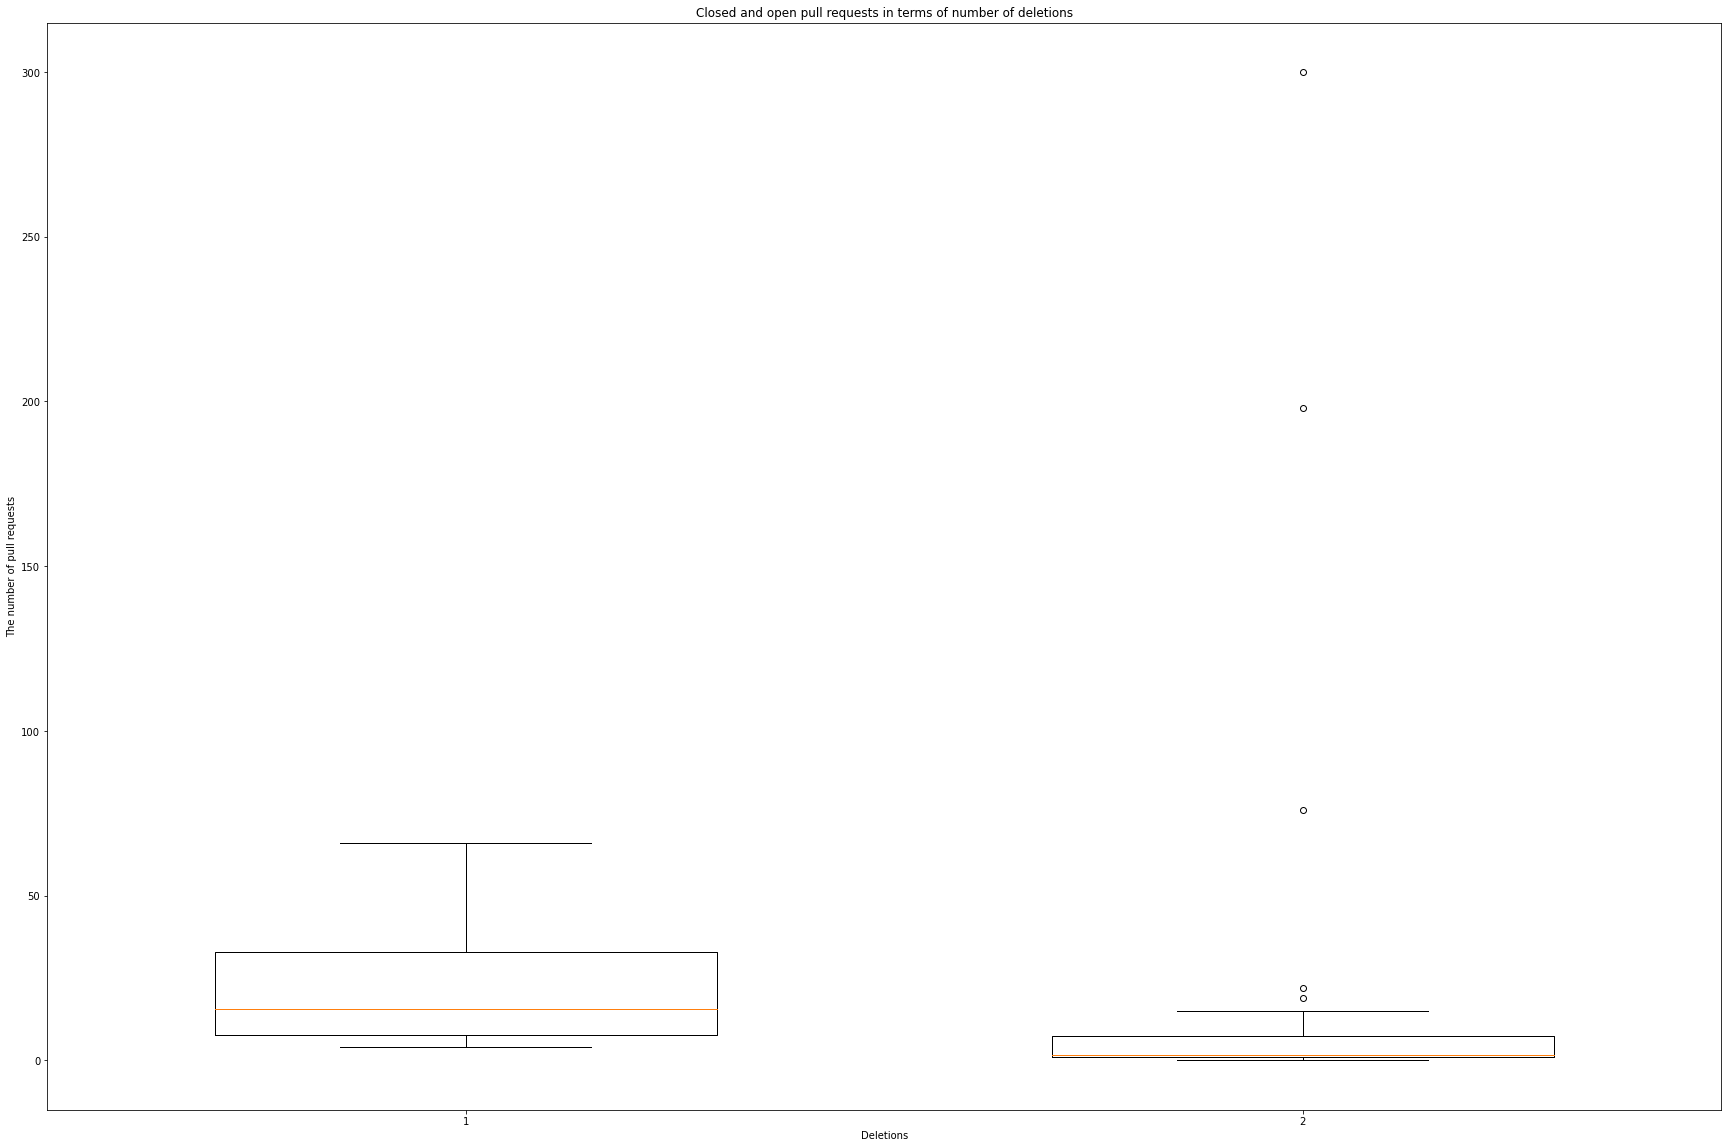

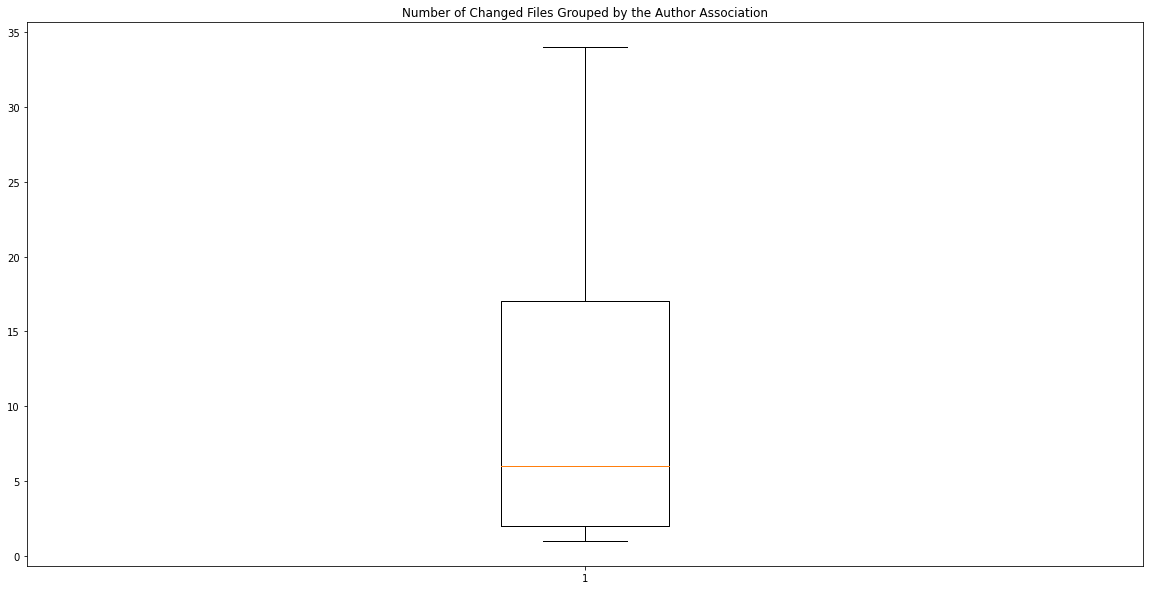

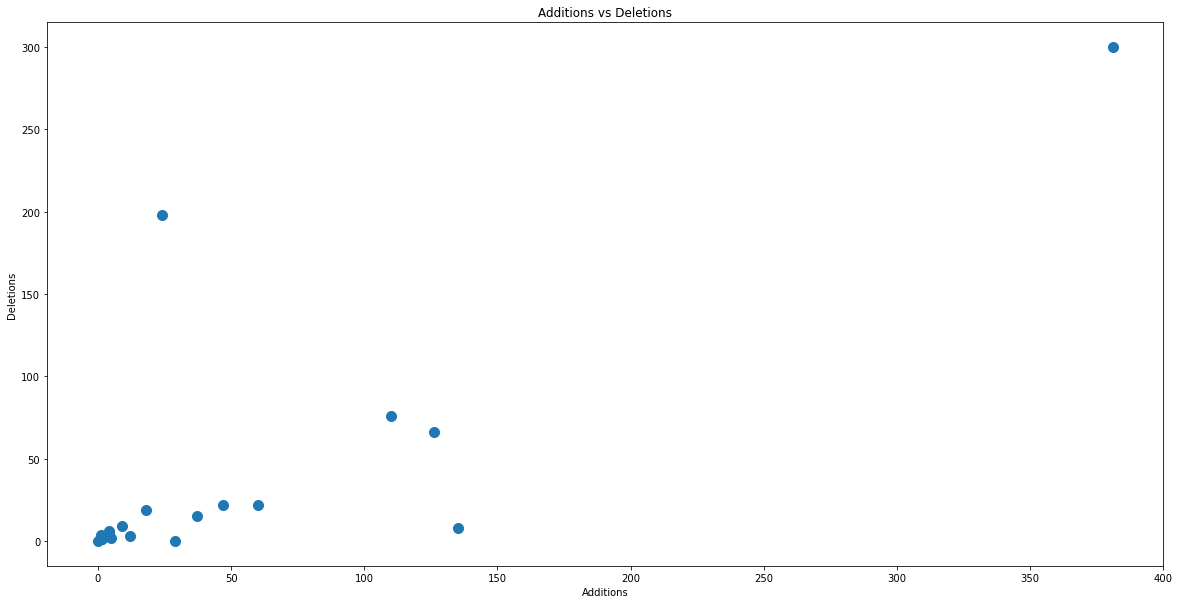

Press enter to continue!

please input one option between 1 to 9:
1---Start to Collect data: 
2---list repos collected
3---list all pull requests from a repo.
4---list the summary of a repo
5---create graphics given a repo
6---create graphics considering ALL pull requests from all repos.
7---calculate the correlation between the data collected for a user (following, followers, number of pull requests, number of contributions, etc.).
8---calculate the correlation between all the numeric data in the pull requests for a repo.
9---exit.
6
./repos/igorsteinmacher-CS499-OSS.csv
./repos/JabRef-jabref.csv
./repos/rails-rails.csv


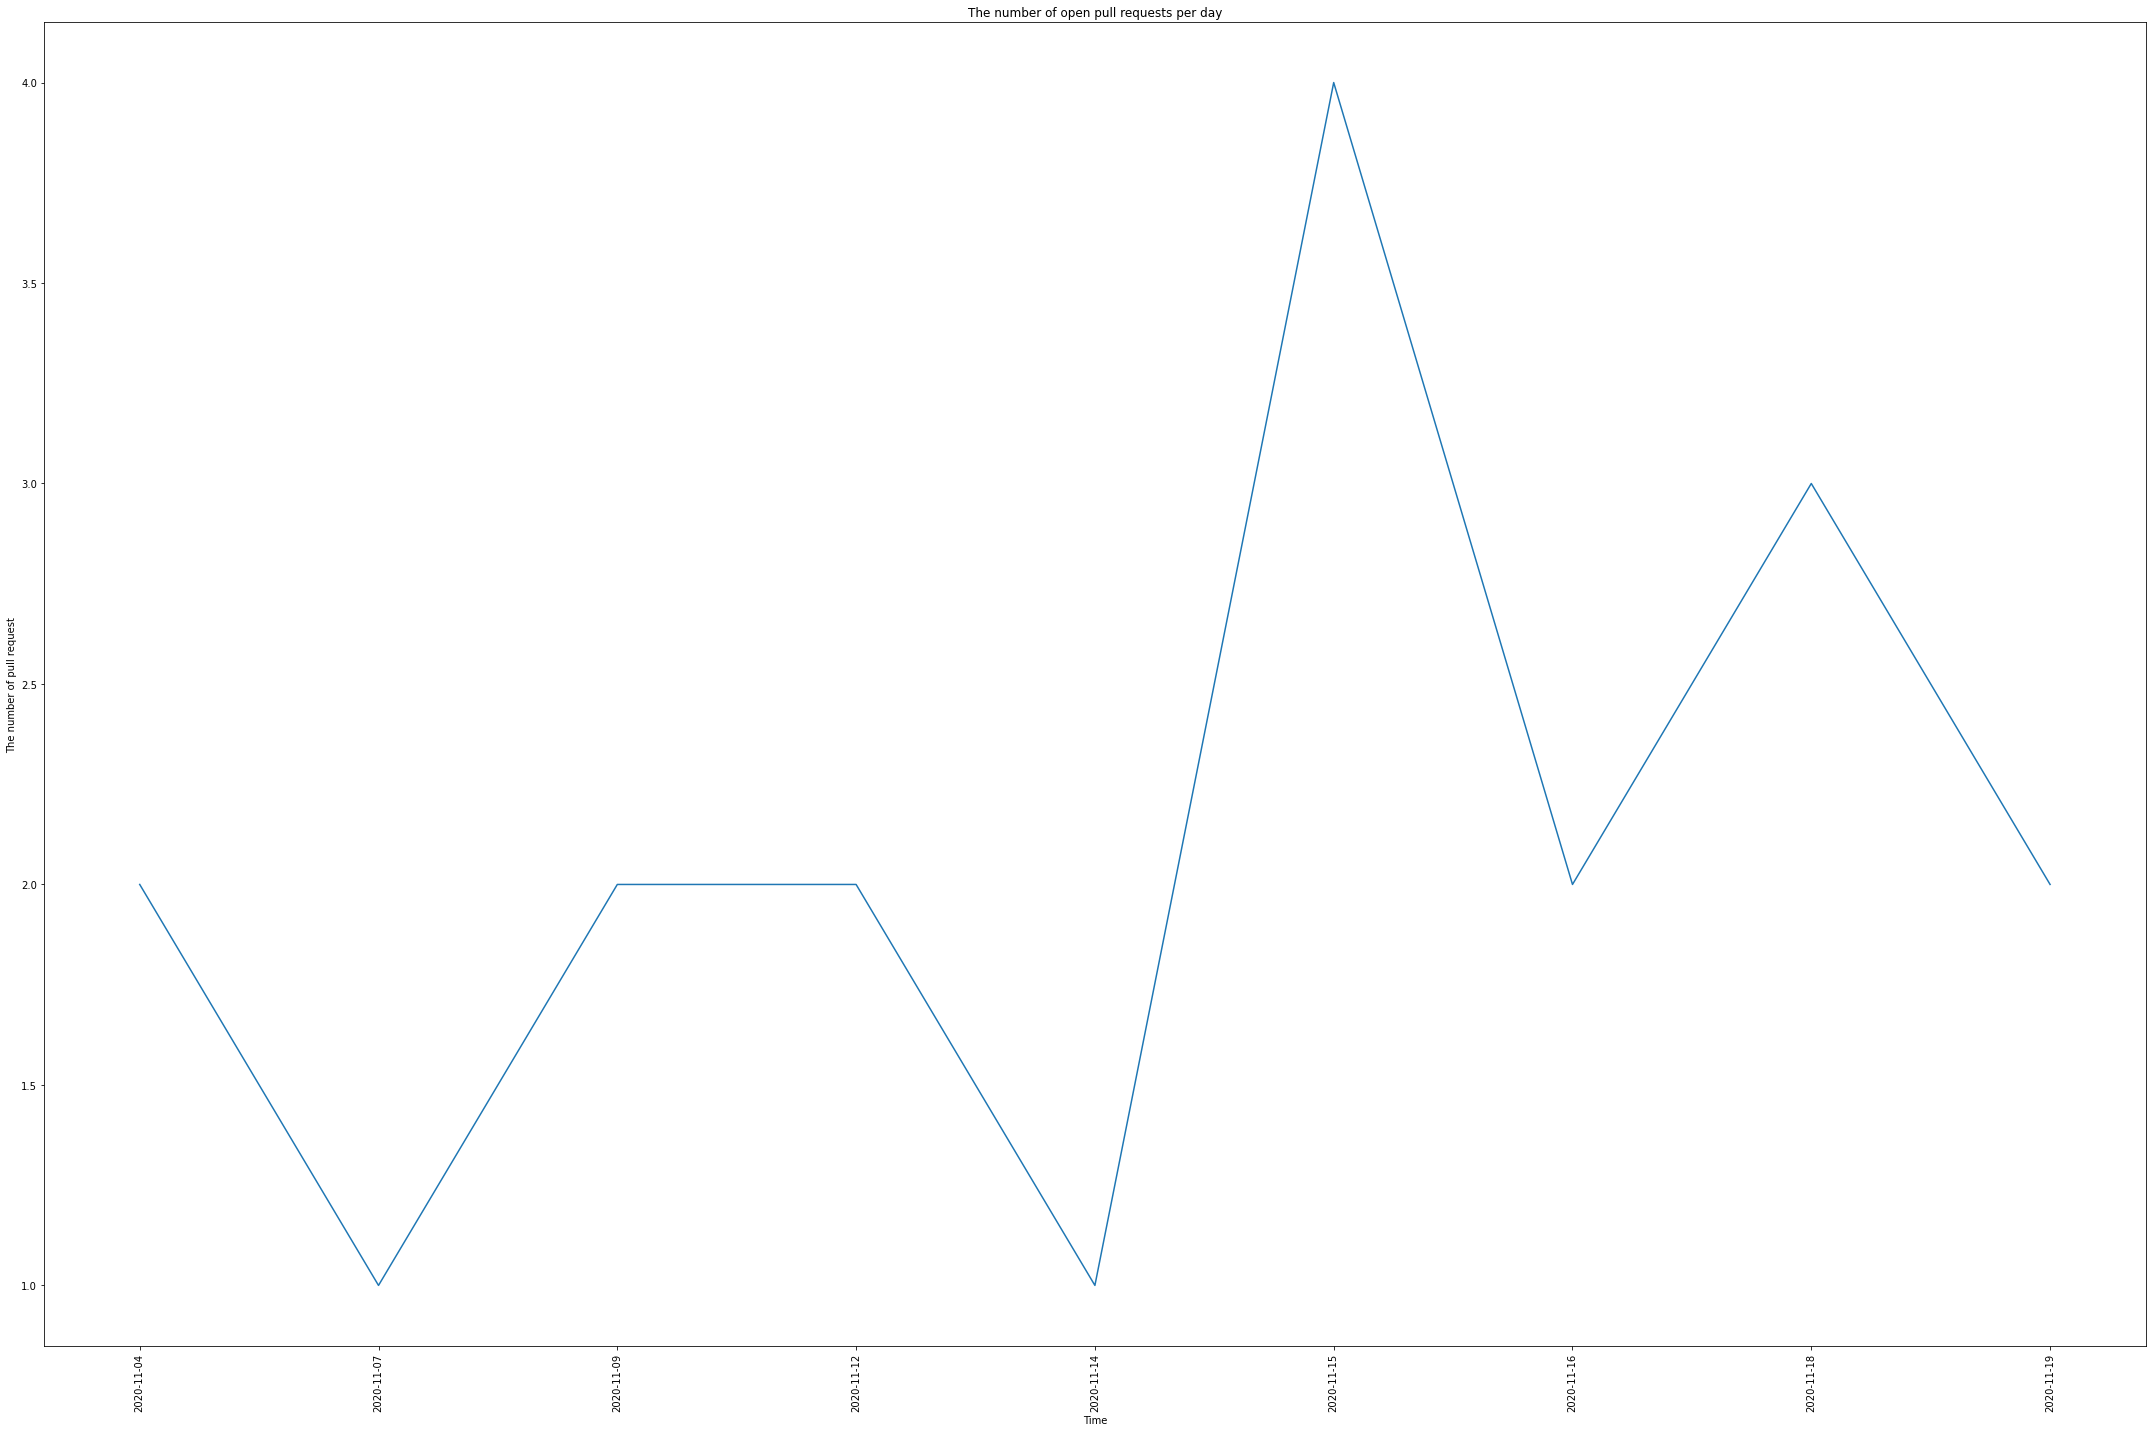

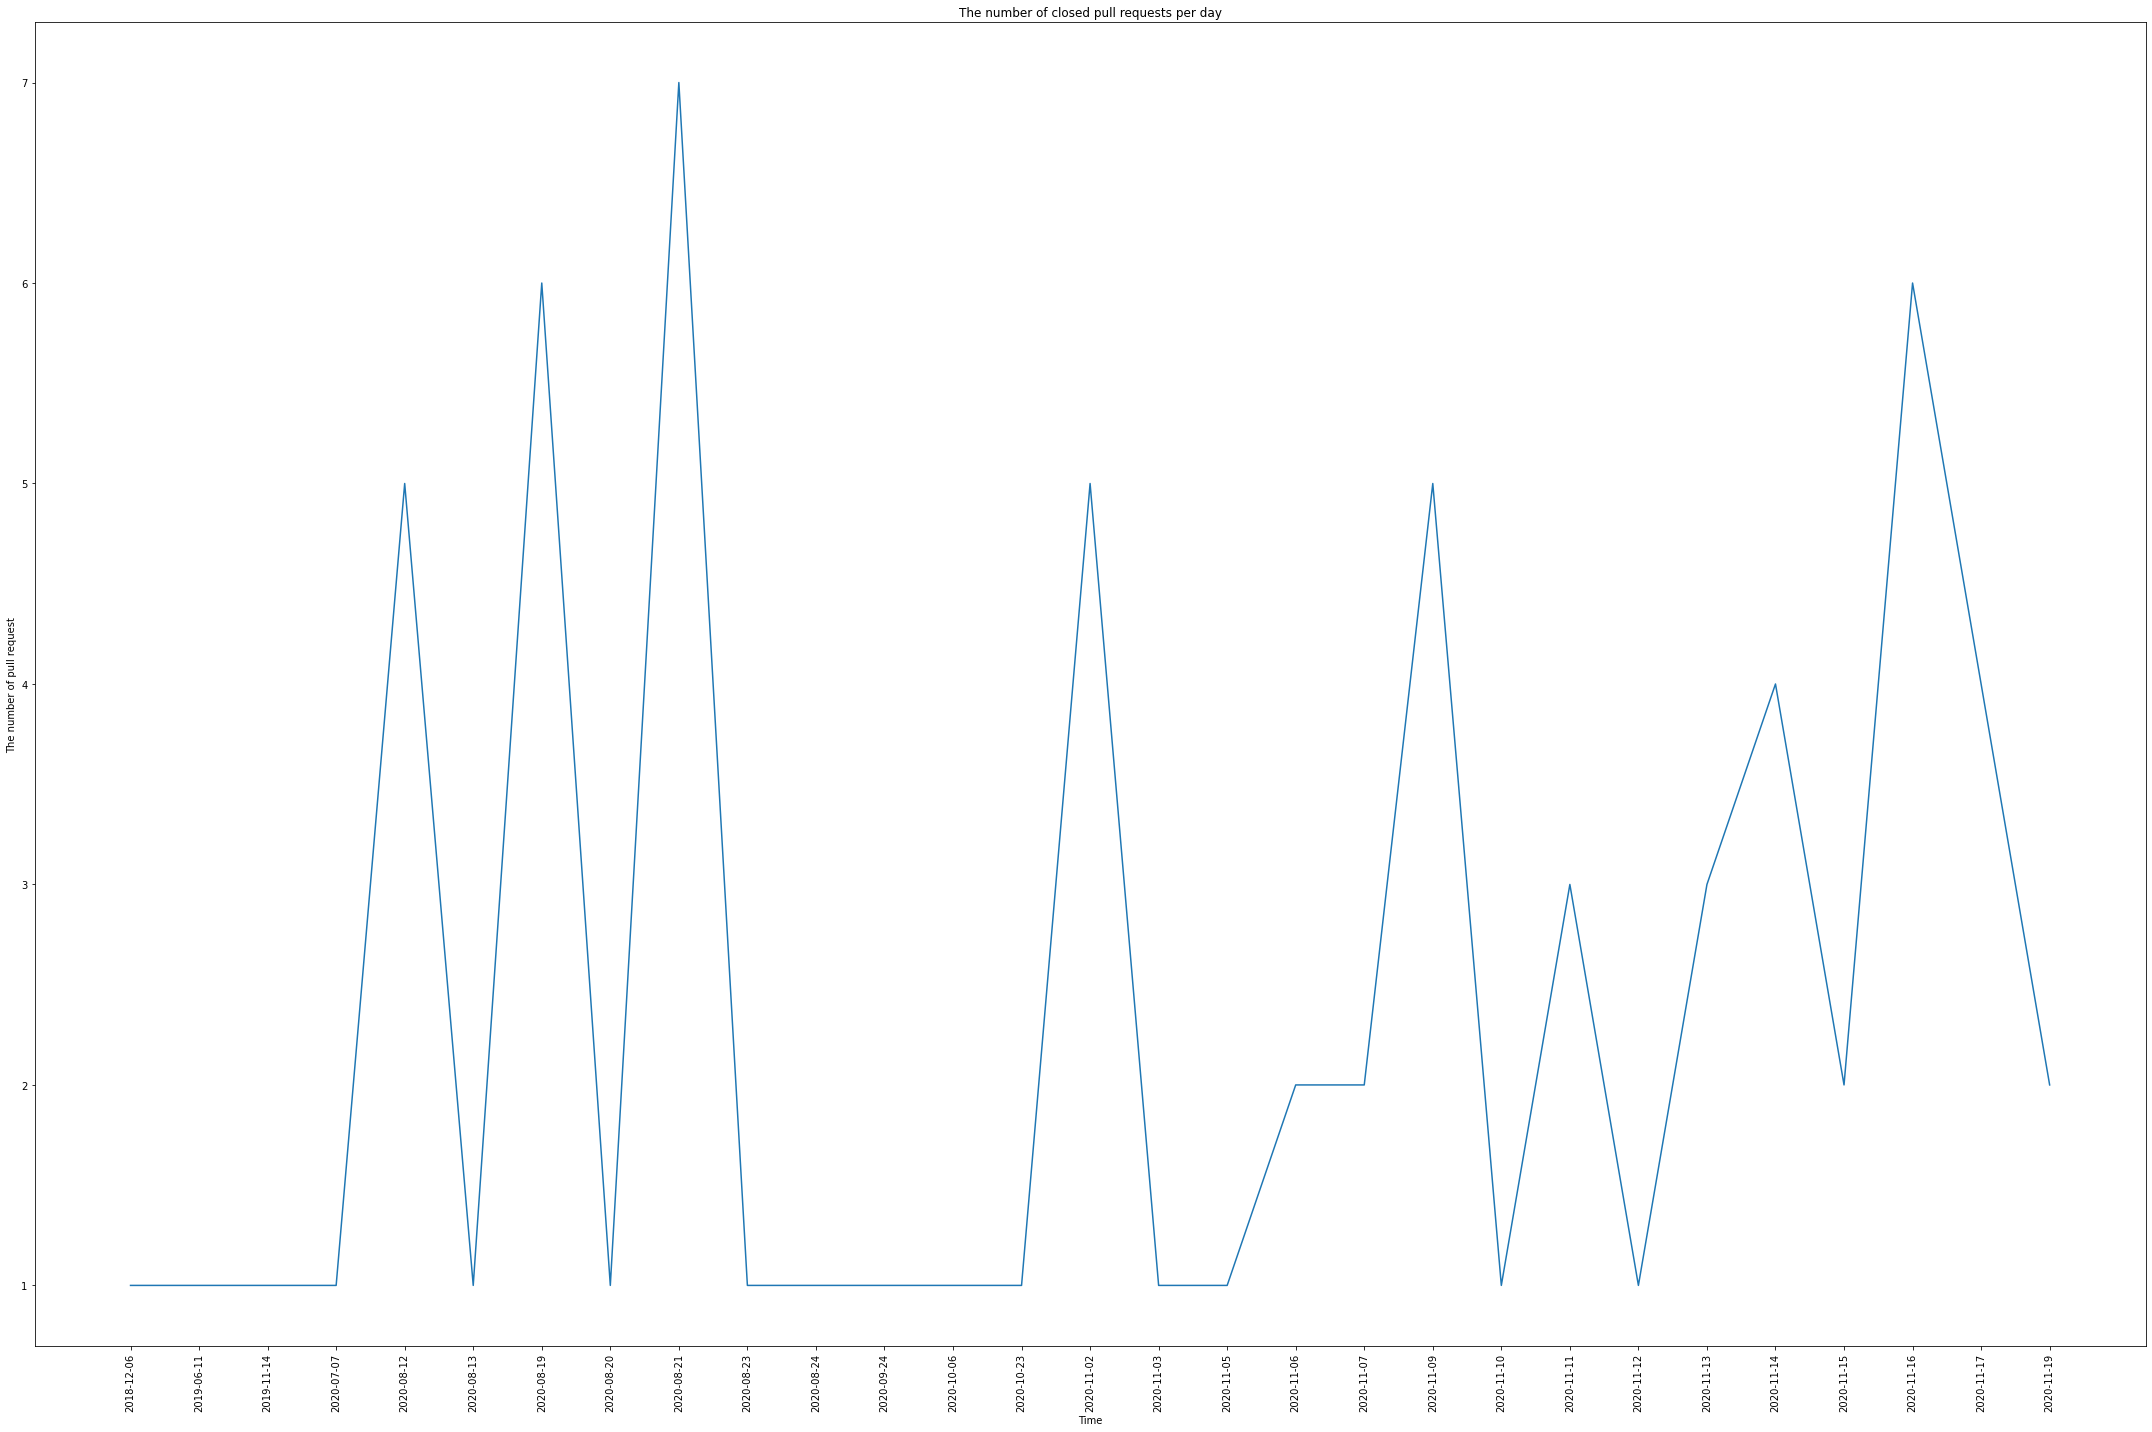

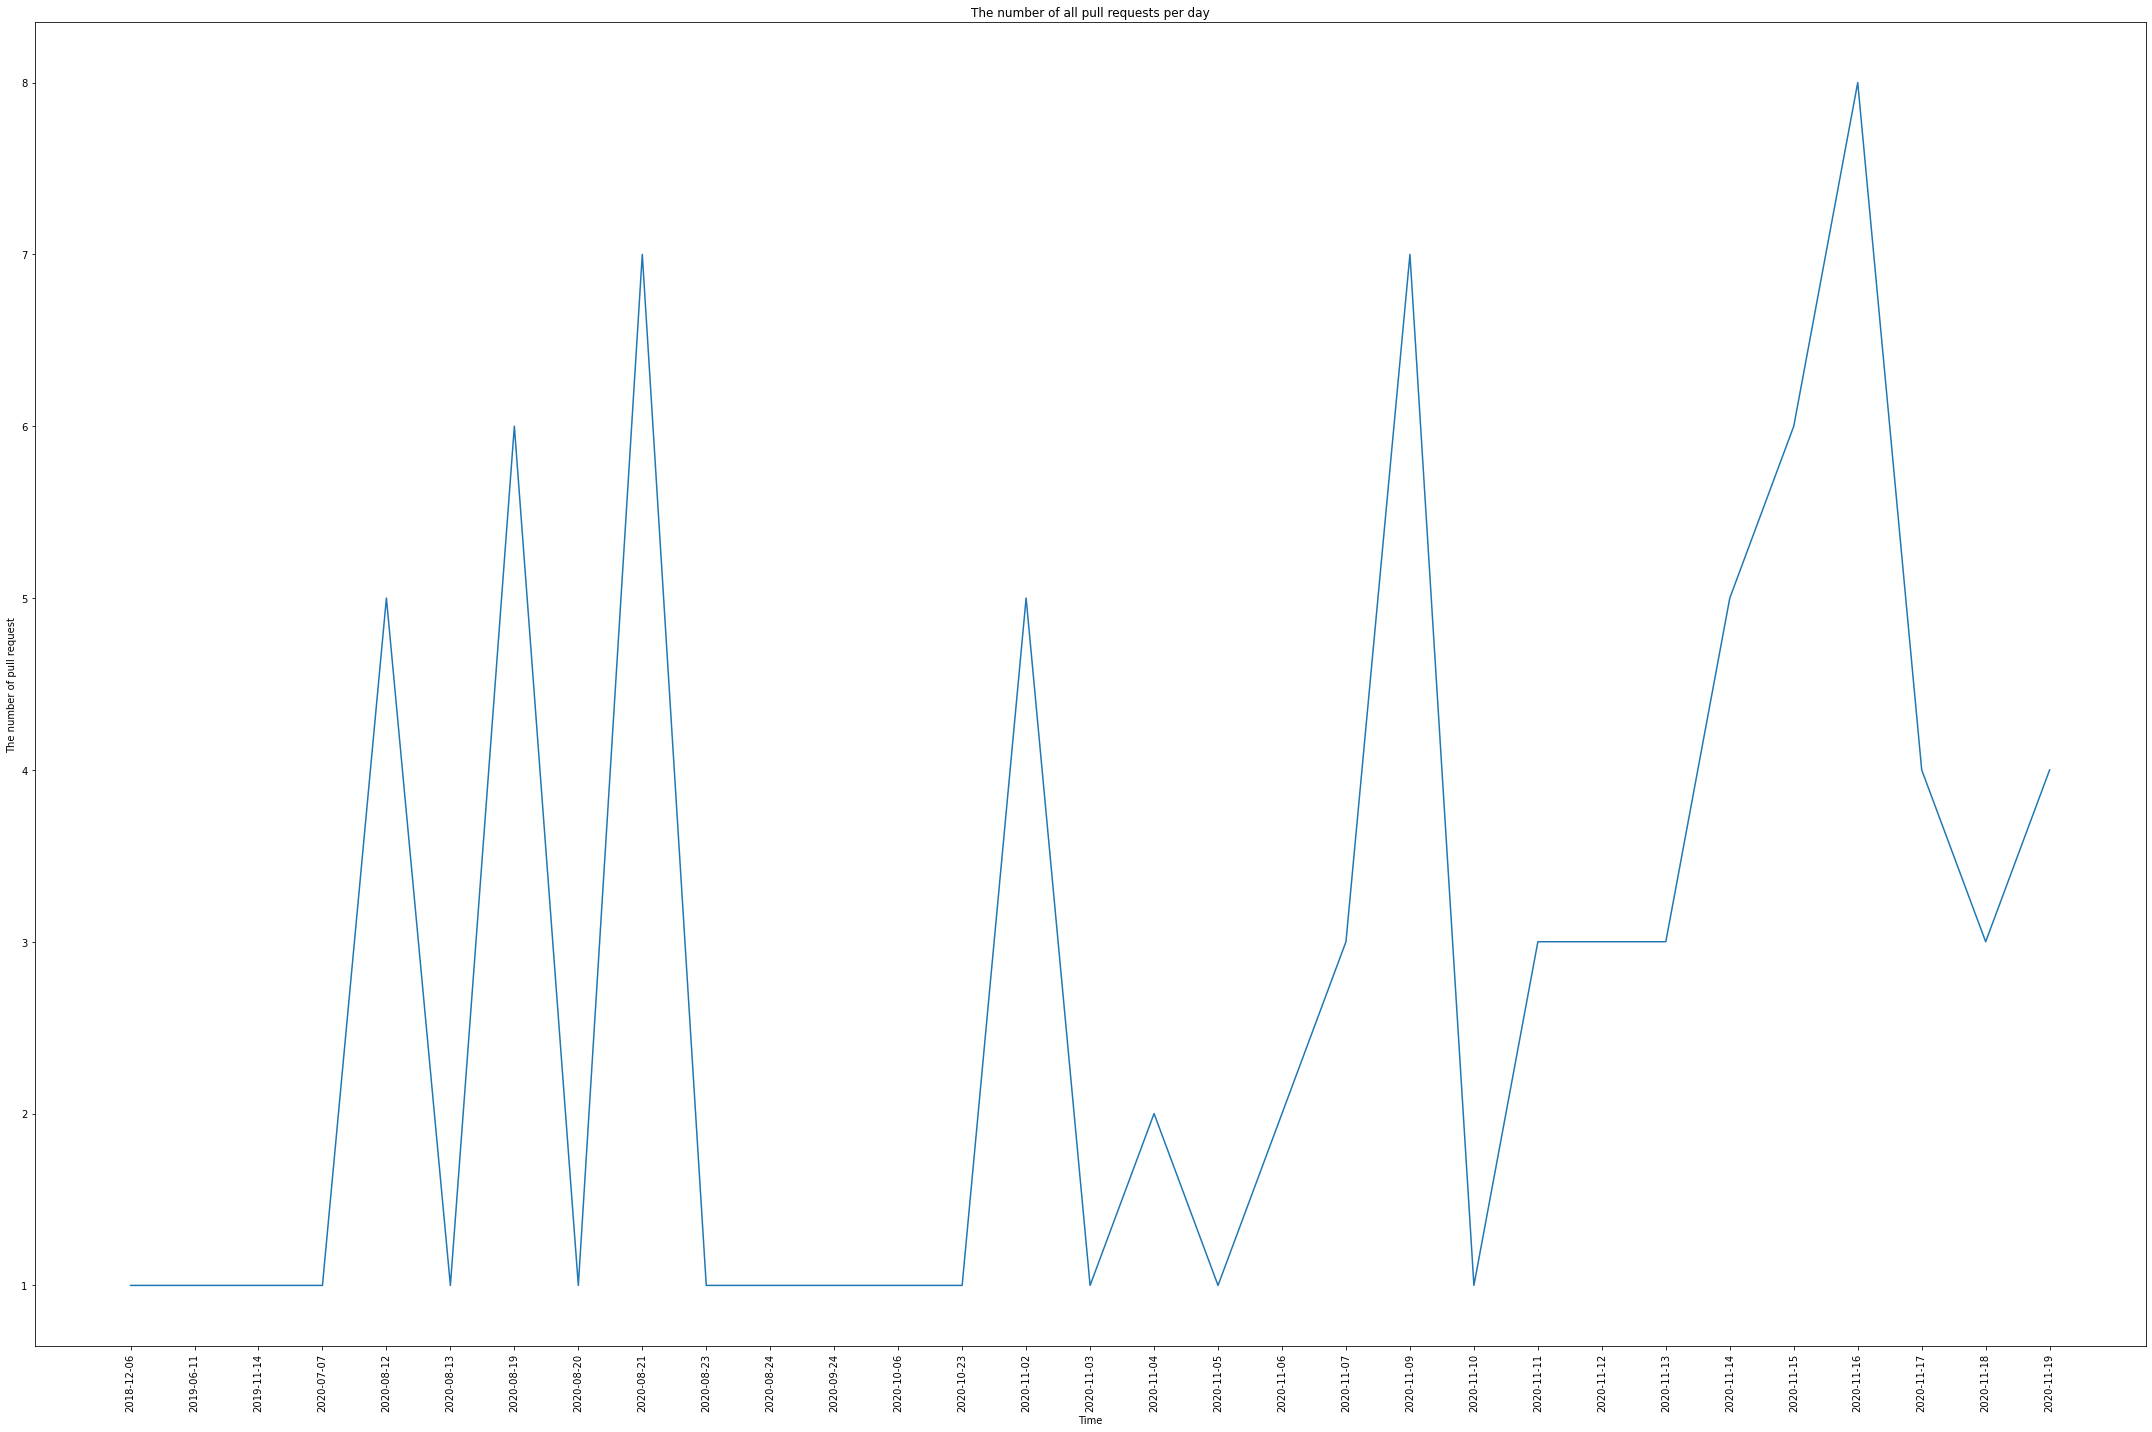

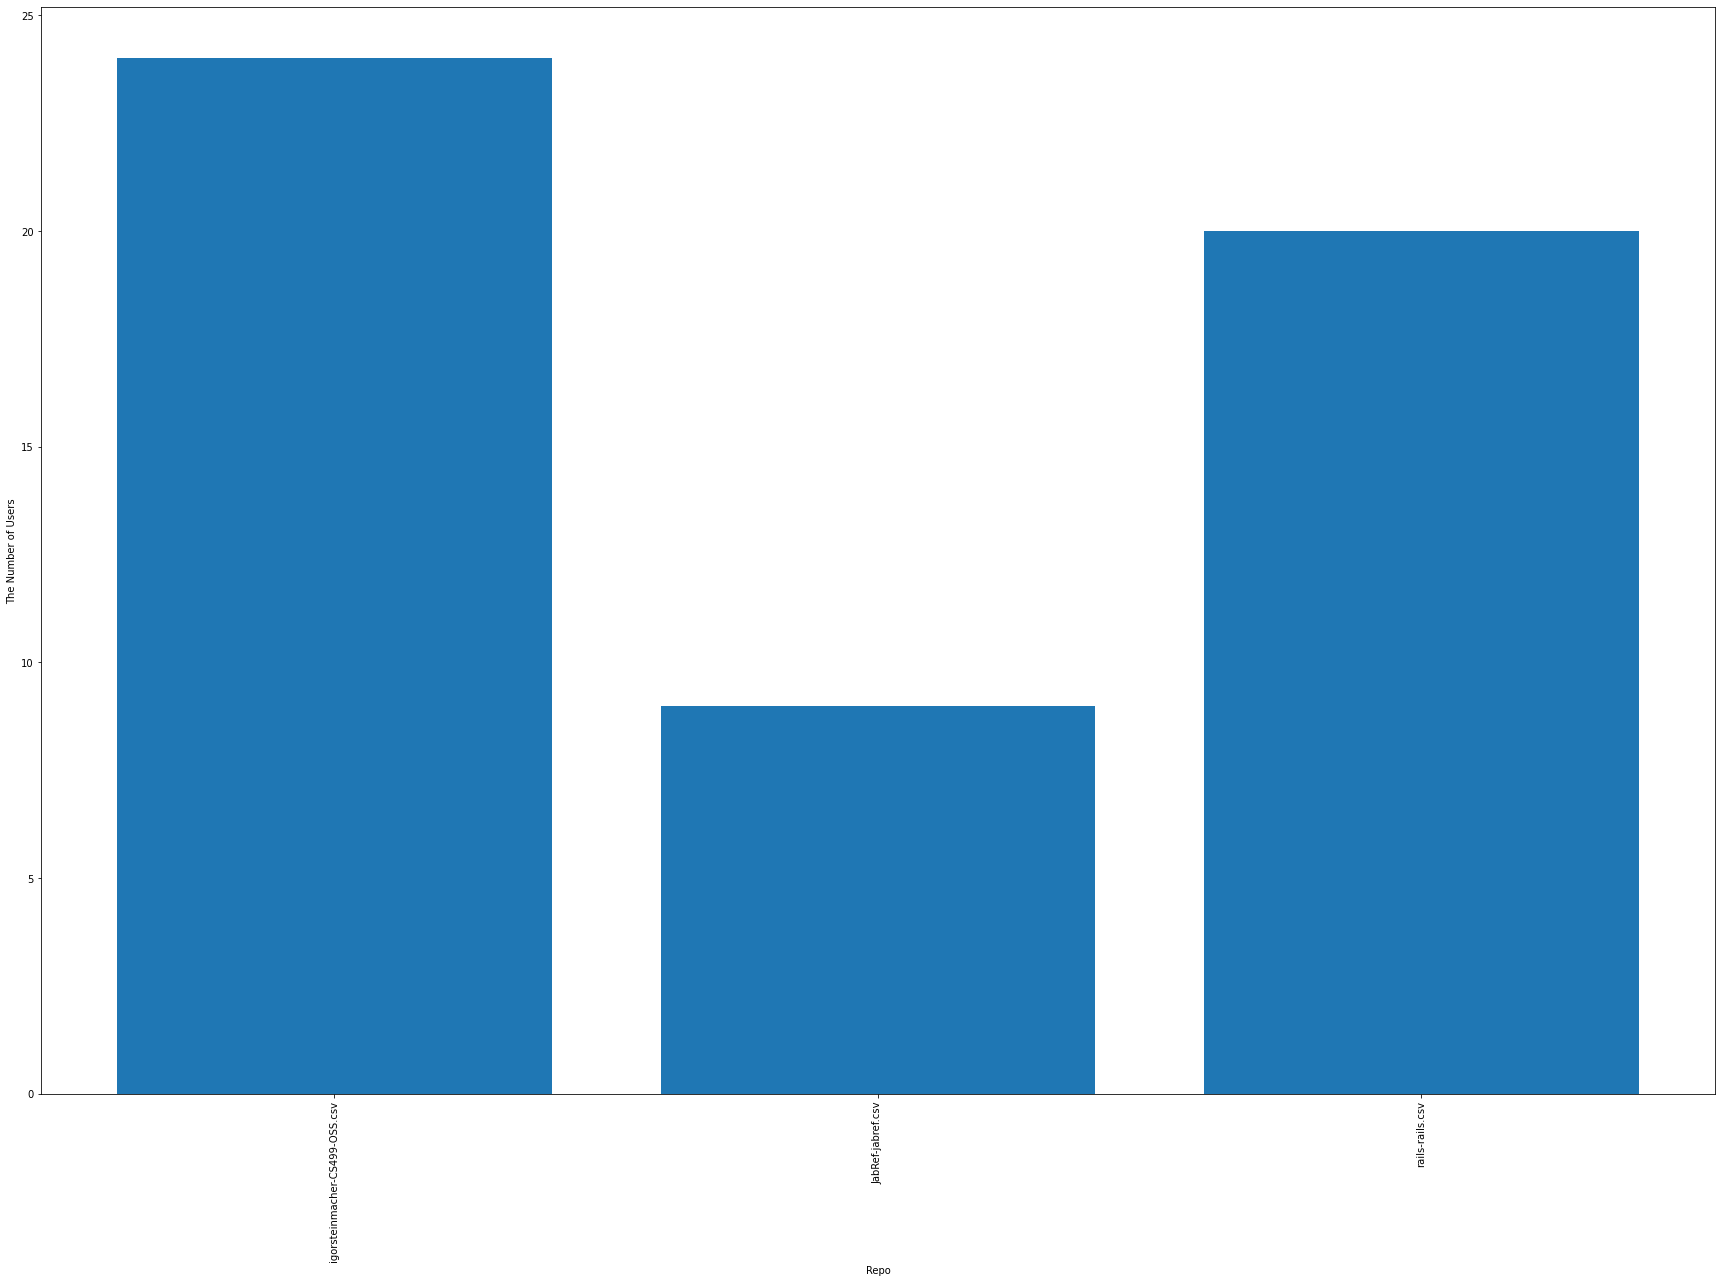

Press enter to continue!

please input one option between 1 to 9:
1---Start to Collect data: 
2---list repos collected
3---list all pull requests from a repo.
4---list the summary of a repo
5---create graphics given a repo
6---create graphics considering ALL pull requests from all repos.
7---calculate the correlation between the data collected for a user (following, followers, number of pull requests, number of contributions, etc.).
8---calculate the correlation between all the numeric data in the pull requests for a repo.
9---exit.
7
                         num_pull_req  num_followers  num_following  \
num_pull_req                 1.000000      -0.011287      -0.004186   
num_followers               -0.011287       1.000000       0.342916   
num_following               -0.004186       0.342916       1.000000   
contributions_last_year      0.030730       0.111433       0.108582   

                         contributions_last_year  
num_pull_req                            0.030730  
n

In [14]:
while True:
    option = input("""
please input one option between 1 to 9:\n\
1---Start to Collect data: \n\
2---list repos collected\n\
3---list all pull requests from a repo.\n\
4---list the summary of a repo\n\
5---create graphics given a repo\n\
6---create graphics considering ALL pull requests from all repos.\n\
7---calculate the correlation between the data collected for a user (following, followers, number of pull requests, number of contributions, etc.).\n\
8---calculate the correlation between all the numeric data in the pull requests for a repo.\n\
9---exit.\n\
""")
    try:
        option = int(option)
    except ValueError:
        print("you give the invalid option: %s" %option)
        input("Press enter to continue!")
        continue
    else:
        if (option>9 or option<1):
            print("You give the invalid option: %s" %option)
            input("Press enter to continue!")
            continue
    if option == 9:
        print("Exited!")
        break
    if option == 1:
        owner = input("input the repo owner name:")
        name = input("input the repo name:")
        if os.path.exists("repos.csv") == True:
            dataset = pd.read_csv("repos.csv", usecols = ["owner", "name"])
            b1 = dataset[dataset["owner"] == owner]
            if b1.shape[0] != 0:
                if len(b1[b1["name"] == name]):
                    print("already collected this repo, try to give another option!")
                    input("Press enter to continue!")
                    continue
        print("Loading ...")
        start_get_data(owner, name)
    elif option == 2:
        list_all_repo()
    elif option == 3:
        list_pull_req_from_repo()
    elif option == 4:
        summary_of_repo()
    elif option == 5:
        print("please select one from repos listed:")
        dataset = pd.read_csv("repos.csv", usecols = ["owner", "name"])
        print(dataset)
        index = int(input("please input the index of the repo (from the first column shown above):"))
        repo = dataset.loc[index]
        create_graphics_repo(repo["owner"], repo["name"])
    elif option == 6:
        create_graphics_all()
    elif option == 7:
        corr_between_datas()
    elif option == 8:
        print("please select one from repos listed:")
        dataset = pd.read_csv("repos.csv", usecols = ["owner", "name"])
        print(dataset)
        index = int(input("please input the index of the repo (from the first column shown above):"))
        repo = dataset.loc[index]
        corr_in_pull_request(repo["owner"], repo["name"])

    input("Press enter to continue!")

In [16]:
class ProjectTestCase(unittest.TestCase, project_info):
    @classmethod
    def setUpClass(cls):
        cls.res = start_get_data("igorsteinmacher", "INF502-Fall2020")
    def test_pull_req_csv(self):
        path = "./repos/"
        filename = self.__class__.res.owner + "-" + self.__class__.res.name + ".csv"
        file = path + filename
        self.assertTrue(os.path.exists(file))
    def test_users_csv(self):
        self.assertTrue(os.path.exists("users.csv"))
    def test_projects_csv(self):
        self.assertTrue(os.path.exists("repos.csv"))
    def test_forks(self):
        self.assertEqual(30, self.res.forks)
    def test_user_info(self):
        dataset = pd.read_csv("./repos/igorsteinmacher-INF502-Fall2020.csv")
        count = dataset.shape[0]
        self.assertEqual(30, count)        
        
if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit = False)

test_forks (__main__.ProjectTestCase) ... ok
test_projects_csv (__main__.ProjectTestCase) ... ok
test_pull_req_csv (__main__.ProjectTestCase) ... ok
test_user_info (__main__.ProjectTestCase) ... ok
test_users_csv (__main__.ProjectTestCase) ... ok

----------------------------------------------------------------------
Ran 5 tests in 57.589s

OK
